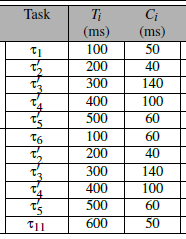

In [129]:
import copy
import random
from operator import itemgetter
import numpy as np

In [130]:
def generates_states_by_rownd(list_st , nT , nP):
  
    list_stp1 = []
    for st in list_st :
      npt = []
      for i in range(nT) :
        sum = 0
        for j in range(nP):
          sum += st[j][i]
        if (sum < 1):
          npt.append(i) #npt: taches non placées
      
      for t in npt :
        for p in range(nP):
          stp1 = copy.deepcopy(st)
          stp1[p][t] = 1
          list_stp1.append(copy.deepcopy(stp1))
          
    return list_stp1

In [131]:
def generate_states( nT, nP):
    n = 0
    list_st = [[[0 for i in range(nT)]for j in range(nP)]]
    states = copy.deepcopy(list_st)
    while(n < nT):
      list_stp1 = generates_states_by_rownd(list_st , nT ,nP)
      list_st = copy.deepcopy(list_stp1)
      states.extend(copy.deepcopy(list_stp1))
      n += 1

    states1 = []
    [states1.append(s) for s in states if s not in states1 ]

    states2 = []
    for s in states1 :
      l = [[] for j in range(nP)]
      for i in range(nP):
        for j in range(nT):
          if s[i][j] == 1:
            l[i].append(j+1)
      states2.append(copy.deepcopy(l)) 
    
    return states2

In [132]:
len(generate_states(2 , 2))

9

In [133]:
def generate_actions(nT, nP):
        i= 0
        actions = []
        for t in range(1, nT+1) : 
          for p in range(1,nP+1):
            actions.append([t,p,i])
            i += 1
        return actions

In [134]:
class ENV(object):

        def __init__(self, numP, Up0, Ut):

            self.Up = [-Up0-0.01  for i in range(numP)]  # [0.86,0.86] processors utilities
            self.Ut = Ut  # [ut1,ut2,ut3] tasks utilities
            self.Up0 = Up0 + 0.01
            self.nonPlacedTasks = [i for i in range(1, len(Ut) + 1)]  # [1,2,3] non placed tasks at t
            self.actions = generate_actions(len(self.Ut), numP)  # all possible actions at t
            self.st = [[] for i in range(numP)]  # current state

        def is_finished(self):  # return true if all tasks are placed and false if not
            return (len(self.nonPlacedTasks) == 0)

        def reset(self, numP, Up0):  # reset the environment to the initial state
            self.Up = [-Up0-0.01 for i in range(numP)]
            self.nonPlacedTasks = [i for i in range(1, len(self.Ut) + 1)]
            self.actions = generate_actions(len(self.Ut), numP)
            self.st = [[] for i in range(numP)]

        def step(self, action):  # return as a result of taking an "action" the new state "stp1" and the reward "R"
            nb = 1
            for p in self.Up:
                if p != -self.Up0:
                    nb += 1

            if (self.Up[action[1] - 1] == -self.Up0):

                R = self.Up[action[1] - 1] * nb
                self.Up[action[1] - 1] = self.Up[action[1] - 1] + self.Ut[action[0] - 1]
            else:
                self.Up[action[1] - 1] = self.Up[action[1] - 1] + self.Ut[action[0] - 1]

                if (self.Up[action[1] - 1] > 0):
                    R = - 10000
                else:
                    R = self.Up[action[1] - 1]
                # separer l'utilite de R

            stp1 = copy.deepcopy(self.st)
            stp1[action[1] - 1].append(action[0])

            for i in range(len(stp1)):
                stp1[i] = sorted(stp1[i])

            return stp1, R

In [135]:
def Max_val(actions , Q , index_stp1): # return max Q value of stp1
  list = []
  for i in range( len(actions) ):
          list.append( Q.item( index_stp1 , actions[i][2] ))
          list = sorted(list, reverse=True)   
  if len(list) == 0 :
    return 0.0
  return list[0] 

In [136]:
discount_factor = 0.8
eps = 1.0          # Amount of randomness in the action selection
eps_decay = 0.001  # 
learning_rate = 0.9
num_episodes = 13000

0.5 , 0.2 , 0.46 , 0.25 , 0.12 , 0.6 , 0.2 , 0.46 , 0.25 , 0.12 , 0.083

Resultat => (6.4) . ((5+10).1) . ((7+2).(8+3)) . ((7+2).(8+3)) . ((10+5).9.4)

In [137]:

env = ENV( 3 , 0.69 , [0.2 , 0.4 , 0.16 , 0.32,0.32 ] )# environment
states = generate_states( len(env.Ut) , len(env.Up)) # all possible states
Q = np.zeros( (len(states), len(env.actions)) ) # Q-table

for i in range(num_episodes) :
    # reset the enviroment to the initial state 
    env.reset( 3 , 0.69 )

    # determin the index of st in the Q table
    index_st = states.index(env.st)

    # Repeat while the tasks are not all placed
    while not env.is_finished():
      l = []  # used in determining the action to take 
      l2 = [] # used in deleting the actions that are not valid anymore 
      
     # choose move with epsilon greedy
      if np.random.random() < eps or np.sum(Q[index_st, :]) == 0:
          #exploration
          action = copy.deepcopy(random.choice(env.actions))
      else: 
          #exploitation
          for i in range( len(env.actions) ):
              l.append([Q.item( index_st , env.actions[i][2] ),  env.actions[i]])
          l = (sorted(l, key=itemgetter(0), reverse=True))
          action = copy.deepcopy(l[0][1])
         
      # execute move
      stp1 , R = env.step(action) 

      # determin the index of stp1 in the Q table so we can update the Q table later on
      index_stp1 = states.index(stp1)

      # remove the task we just placed from the list
      env.nonPlacedTasks.remove(action[0]) 

      # remove all actions of placing  that task from the actions list
      for a in env.actions:             
        if(a[0] != action[0]):          
          l2.append(a)                  
      env.actions = copy.deepcopy(l2)   

      # update Q table
      Q[index_st][action[2]] = Q[index_st][action[2]]+ learning_rate * (R + discount_factor *  Max_val(env.actions, Q, index_stp1) - Q[index_st][action[2]]) 

      # update st to stp1
      env.st = stp1 
      index_st = index_stp1
      eps = max(eps - eps_decay, 0)
Q = np.around(Q, decimals=3)    



In [138]:


actions = generate_actions( len(env.Ut), len(env.Up) )
for i in range(len(states)):
  for j in range(len(actions)):
    if (Q.item(i,j) == 0.0 ):
        Q[i][j] = -1000.0

S = np.empty((len(states),1), dtype=object)


for i in range(len(states)):
  
  str1 = ' '.join([str(elem) for elem in copy.deepcopy(states[i][0])])
  str2  = ' '.join([str(elem) for elem in copy.deepcopy(states[i][1])])
  str3  = ' '.join([str(elem) for elem in copy.deepcopy(states[i][2])])
  str4 = '['+ str1 +']'+'  ['+str2+']'+'  ['+str3+']'
  S[i] = str4

Q1 = np.concatenate((S,Q),axis=1)
i=0



In [139]:
s = [[] for i in range(len(env.Up))]

for i in range(len(env.Ut)) :
    index_s = states.index(s)
    a = actions[ np.argmax(Q[index_s,:])]
    s[ a[1]-1 ].append(a[0])
    for i in range(len(s)) :
            s[i] = sorted(s[i])
  

s

[[1, 3, 4], [2], [5]]